# Neural Network in predicting Solar Generation:
### This workbook demonstrates how neural network can be used with NREL weather data to predict Texas ERCOT solar generation. In addition, different options of building the network was investigated to pick out model parameters best fit our purpose.

Import necessary modules:

In [2]:
import numpy as np
import pandas as pd
import datetime
import math
import matplotlib.pyplot as plt
import seaborn as sns

import os
import requests
import zipfile

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
scaler = preprocessing.StandardScaler()

Import the database containing weather and solar generation data:

In [14]:
all_data_df = pd.read_csv('../../energyforecaster/data/normalized_by_2000_dtpts.csv')
all_data_df.head()

Unnamed: 0  DHI  DNI  GHI  Clearsky DHI  Clearsky DNI  Clearsky GHI  \
0           0   13    0   13            50           204            77   
1           1   65    0   65            81           356           160   
2           2   10    0   10            99           487           248   
3           3   14    0   14           114           566           331   
4           4   31    0   31           119           643           409   

   Cloud Type  Dew Point  Solar Zenith Angle  ...  Precipitable Water  \
0           4       10.0               82.67  ...               3.814   
1           8       10.0               77.27  ...               3.741   
2           7       10.0               72.18  ...               3.669   
3           8       10.0               67.46  ...               3.601   
4           4       10.0               63.22  ...               3.534   

   Wind Direction  Relative Humidity  Temperature  Pressure     Solar  \
0           355.2              96.35         11.0    1010.0  0.000080   
1           355.2              96.38         11.0    1010.0  0.184486   
2             1.7              96.05         11.0    1010.0  0.472936   
3             1.7              96.08         11.0    1010.0  0.919004   
4             5.4              89.10         12.0    1010.0  1.363654   

   Normalized_Solar_lin  Normalized_Solar_geom  Normalized_Solar  \
0          9.756098e-07           9.756098e-07      6.611570e-07   
1          2.249829e-03           2.249829e-03      1.524678e-03   
2          5.767512e-03           5.767512e-03      3.908562e-03   
3          1.120737e-02           1.120737e-02      7.595074e-03   
4          1.662993e-02           1.662993e-02      1.126987e-02   

   normalized_solar  
0          0.000004  
1          0.010323  
2          0.026463  
3          0.051423  
4          0.076303  

[5 rows x 22 columns]

Trimming unnecessary columns:

In [15]:
for label in ['Unnamed: 0', 'Date', 'hhmm','Installed', 'Fill Flag']:
    if label in all_data_df.columns:
        all_data_df.drop(label,axis=1,inplace=True)

Based on Random Forests results and what weather data are available the feature list below is chosen for neural network exploration:
1. Relative Humidity
2. Solar Zenith Angle
3. GHI
4. Wind Direction
5. Temperature
6. Wind Speed
7. DNI
8. DHI
9. Pressure

The data is transformed and normalized to be used with neural network algorithm:

In [16]:
feature_list = ['Relative Humidity', 'Solar Zenith Angle', 'GHI','Wind Direction','Temperature','Wind Speed','DNI','DHI','Pressure']
prediction = ['normalized_solar']

#scaling data:
X_pn = all_data_df[feature_list]
y_pn = np.array(all_data_df[prediction])
X_normalized = scaler.fit_transform(X_pn)

### KFold validation using 1 hidden layer with 100 nodes:

TRAIN: [    0     1     2 ... 51466 51467 51468] TEST: [   10    28    44 ... 51437 51442 51444]
Set 1
R-squared of training data is: 0.670, 0.670
R-squared of testing data is: 0.645, 0.645
TRAIN: [    0     1     3 ... 51466 51467 51468] TEST: [    2    12    23 ... 51416 51417 51435]
Set 2
R-squared of training data is: 0.671, 0.671
R-squared of testing data is: 0.665, 0.665
TRAIN: [    0     1     2 ... 51466 51467 51468] TEST: [    3     8    11 ... 51436 51449 51465]
Set 3
R-squared of training data is: 0.673, 0.673
R-squared of testing data is: 0.668, 0.668
TRAIN: [    0     1     2 ... 51465 51467 51468] TEST: [   19    21    22 ... 51462 51463 51466]
Set 4
R-squared of training data is: 0.670, 0.670
R-squared of testing data is: 0.644, 0.644
TRAIN: [    0     1     2 ... 51466 51467 51468] TEST: [   26    35    36 ... 51403 51405 51424]
Set 5
R-squared of training data is: 0.667, 0.667
R-squared of testing data is: 0.657, 0.657
TRAIN: [    1     2     3 ... 51466 51467 51468] T

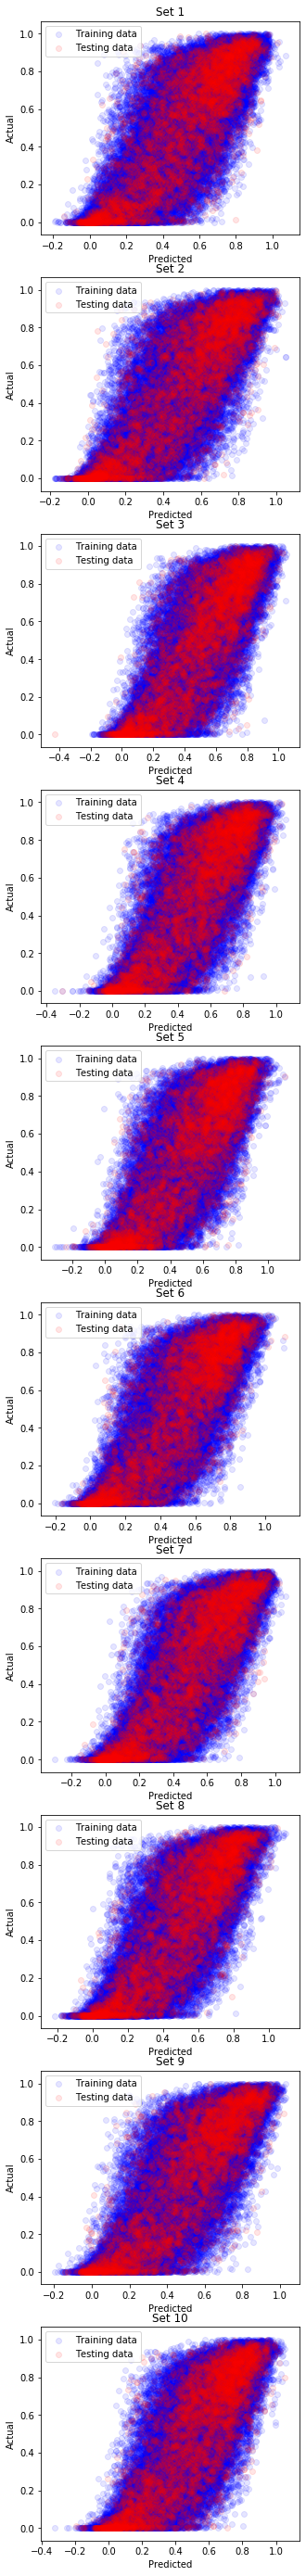

In [8]:
kf = KFold(n_splits=10,random_state=1,shuffle=True)# Define the split - into 100 folds 

fig, axs = plt.subplots(10, 1, figsize=(5,50))

i=0

for train_index, test_index in kf.split(X_normalized, y_pn):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, y_train = X_normalized[train_index], y_pn[train_index].reshape(-1)
    X_test, y_test = X_normalized[test_index], y_pn[test_index].reshape(-1)
    clf = MLPRegressor(solver='lbfgs',hidden_layer_sizes=(100,))
    clf.fit(X_train,y_train)
    print('Set '+str(i+1))
    print('R-squared of training data is: '+"{:.3f}".format(r2_score(y_train,clf.predict(X_train)))+', '+"{:.3f}".format(clf.score(X_train,y_train)))
    print('R-squared of testing data is: '+"{:.3f}".format(r2_score(y_test,clf.predict(X_test)))+', '+"{:.3f}".format(clf.score(X_test,y_test)))
    axs[i].scatter(clf.predict(X_train), y_train, alpha = 0.1, color='blue')
    axs[i].scatter(clf.predict(X_test), y_test, alpha = 0.1, color='red')
    axs[i].set_title('Set '+str(i+1), fontsize=12)
    axs[i].set_xlabel('Predicted')
    axs[i].set_ylabel('Actual')
    axs[i].legend(('Training data', 'Testing data'))
    i=i+1

### KFold validation using 1 hidden layer with 50 nodes:

TRAIN: [    0     1     2 ... 51466 51467 51468] TEST: [   10    28    44 ... 51437 51442 51444]
Set 1
R-squared of training data is: 0.653, 0.653
R-squared of testing data is: 0.635, 0.635
TRAIN: [    0     1     3 ... 51466 51467 51468] TEST: [    2    12    23 ... 51416 51417 51435]
Set 2
R-squared of training data is: 0.649, 0.649
R-squared of testing data is: 0.651, 0.651
TRAIN: [    0     1     2 ... 51466 51467 51468] TEST: [    3     8    11 ... 51436 51449 51465]
Set 3
R-squared of training data is: 0.653, 0.653
R-squared of testing data is: 0.652, 0.652
TRAIN: [    0     1     2 ... 51465 51467 51468] TEST: [   19    21    22 ... 51462 51463 51466]
Set 4
R-squared of training data is: 0.654, 0.654
R-squared of testing data is: 0.636, 0.636
TRAIN: [    0     1     2 ... 51466 51467 51468] TEST: [   26    35    36 ... 51403 51405 51424]
Set 5
R-squared of training data is: 0.648, 0.648
R-squared of testing data is: 0.642, 0.642
TRAIN: [    1     2     3 ... 51466 51467 51468] T

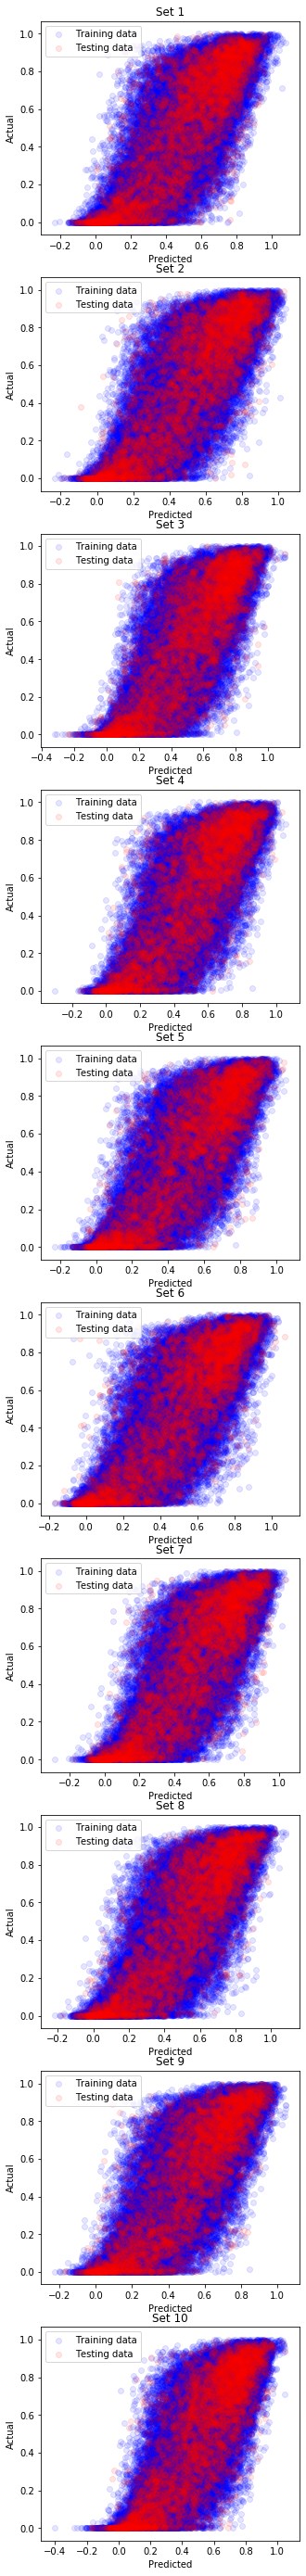

In [9]:
kf = KFold(n_splits=10,random_state=1,shuffle=True)# Define the split - into 100 folds 

fig, axs = plt.subplots(10, 1, figsize=(5,50))

i=0

for train_index, test_index in kf.split(X_normalized, y_pn):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, y_train = X_normalized[train_index], y_pn[train_index].reshape(-1)
    X_test, y_test = X_normalized[test_index], y_pn[test_index].reshape(-1)
    clf = MLPRegressor(solver='lbfgs',hidden_layer_sizes=(50,))
    clf.fit(X_train,y_train)
    print('Set '+str(i+1))
    print('R-squared of training data is: '+"{:.3f}".format(r2_score(y_train,clf.predict(X_train)))+', '+"{:.3f}".format(clf.score(X_train,y_train)))
    print('R-squared of testing data is: '+"{:.3f}".format(r2_score(y_test,clf.predict(X_test)))+', '+"{:.3f}".format(clf.score(X_test,y_test)))
    axs[i].scatter(clf.predict(X_train), y_train, alpha = 0.1, color='blue')
    axs[i].scatter(clf.predict(X_test), y_test, alpha = 0.1, color='red')
    axs[i].set_title('Set '+str(i+1), fontsize=12)
    axs[i].set_xlabel('Predicted')
    axs[i].set_ylabel('Actual')
    axs[i].legend(('Training data', 'Testing data'))
    i=i+1

### KFold validation using 2 hidden layers with 25 nodes each:

TRAIN: [    0     1     2 ... 51466 51467 51468] TEST: [   10    28    44 ... 51437 51442 51444]
Set 1
R-squared of training data is: 0.664, 0.664
R-squared of testing data is: 0.644, 0.644
TRAIN: [    0     1     3 ... 51466 51467 51468] TEST: [    2    12    23 ... 51416 51417 51435]
Set 2
R-squared of training data is: 0.667, 0.667
R-squared of testing data is: 0.668, 0.668
TRAIN: [    0     1     2 ... 51466 51467 51468] TEST: [    3     8    11 ... 51436 51449 51465]
Set 3
R-squared of training data is: 0.656, 0.656
R-squared of testing data is: 0.657, 0.657
TRAIN: [    0     1     2 ... 51465 51467 51468] TEST: [   19    21    22 ... 51462 51463 51466]
Set 4
R-squared of training data is: 0.661, 0.661
R-squared of testing data is: 0.643, 0.643
TRAIN: [    0     1     2 ... 51466 51467 51468] TEST: [   26    35    36 ... 51403 51405 51424]
Set 5
R-squared of training data is: 0.659, 0.659
R-squared of testing data is: 0.659, 0.659
TRAIN: [    1     2     3 ... 51466 51467 51468] T

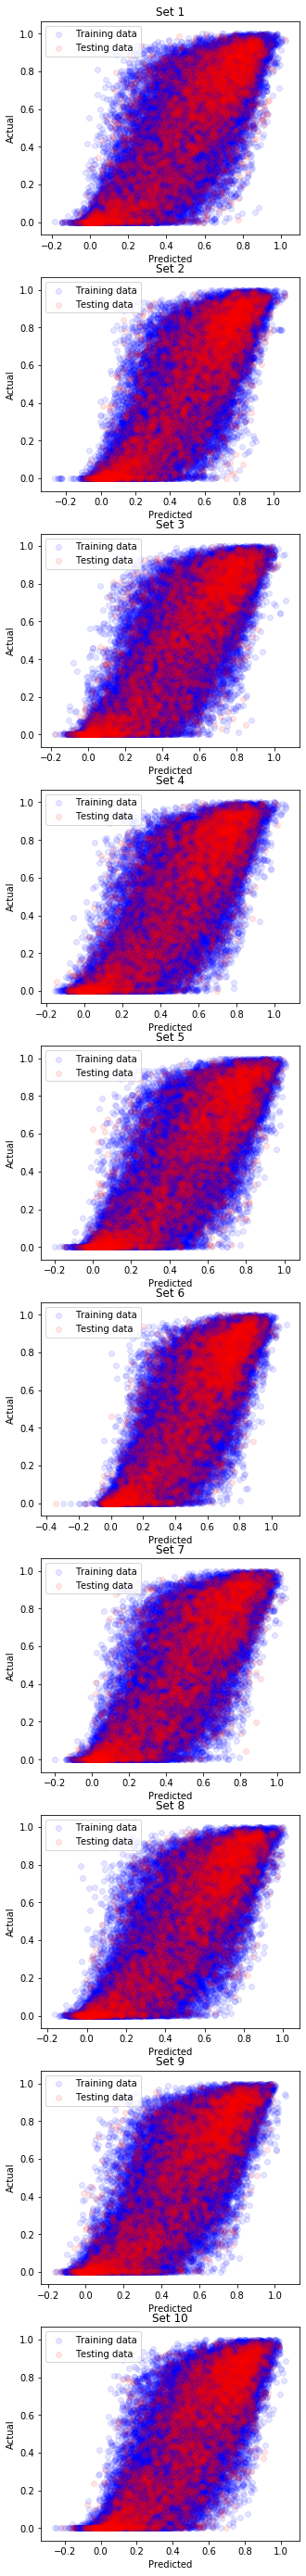

In [10]:
kf = KFold(n_splits=10,random_state=1,shuffle=True)# Define the split - into 100 folds 

fig, axs = plt.subplots(10, 1, figsize=(5,50))

i=0

for train_index, test_index in kf.split(X_normalized, y_pn):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, y_train = X_normalized[train_index], y_pn[train_index].reshape(-1)
    X_test, y_test = X_normalized[test_index], y_pn[test_index].reshape(-1)
    clf = MLPRegressor(solver='lbfgs',hidden_layer_sizes=(25,25))
    clf.fit(X_train,y_train)
    print('Set '+str(i+1))
    print('R-squared of training data is: '+"{:.3f}".format(r2_score(y_train,clf.predict(X_train)))+', '+"{:.3f}".format(clf.score(X_train,y_train)))
    print('R-squared of testing data is: '+"{:.3f}".format(r2_score(y_test,clf.predict(X_test)))+', '+"{:.3f}".format(clf.score(X_test,y_test)))
    axs[i].scatter(clf.predict(X_train), y_train, alpha = 0.1, color='blue')
    axs[i].scatter(clf.predict(X_test), y_test, alpha = 0.1, color='red')
    axs[i].set_title('Set '+str(i+1), fontsize=12)
    axs[i].set_xlabel('Predicted')
    axs[i].set_ylabel('Actual')
    axs[i].legend(('Training data', 'Testing data'))
    i=i+1

### KFold validation using 2 hidden layers with 50 nodes each:

TRAIN: [    0     1     2 ... 51466 51467 51468] TEST: [   10    28    44 ... 51437 51442 51444]
Set 1
R-squared of training data is: 0.684, 0.684
R-squared of testing data is: 0.656, 0.656
TRAIN: [    0     1     3 ... 51466 51467 51468] TEST: [    2    12    23 ... 51416 51417 51435]
Set 2
R-squared of training data is: 0.678, 0.678
R-squared of testing data is: 0.675, 0.675
TRAIN: [    0     1     2 ... 51466 51467 51468] TEST: [    3     8    11 ... 51436 51449 51465]
Set 3
R-squared of training data is: 0.678, 0.678
R-squared of testing data is: 0.670, 0.670
TRAIN: [    0     1     2 ... 51465 51467 51468] TEST: [   19    21    22 ... 51462 51463 51466]
Set 4
R-squared of training data is: 0.685, 0.685
R-squared of testing data is: 0.657, 0.657
TRAIN: [    0     1     2 ... 51466 51467 51468] TEST: [   26    35    36 ... 51403 51405 51424]
Set 5
R-squared of training data is: 0.680, 0.680
R-squared of testing data is: 0.669, 0.669
TRAIN: [    1     2     3 ... 51466 51467 51468] T

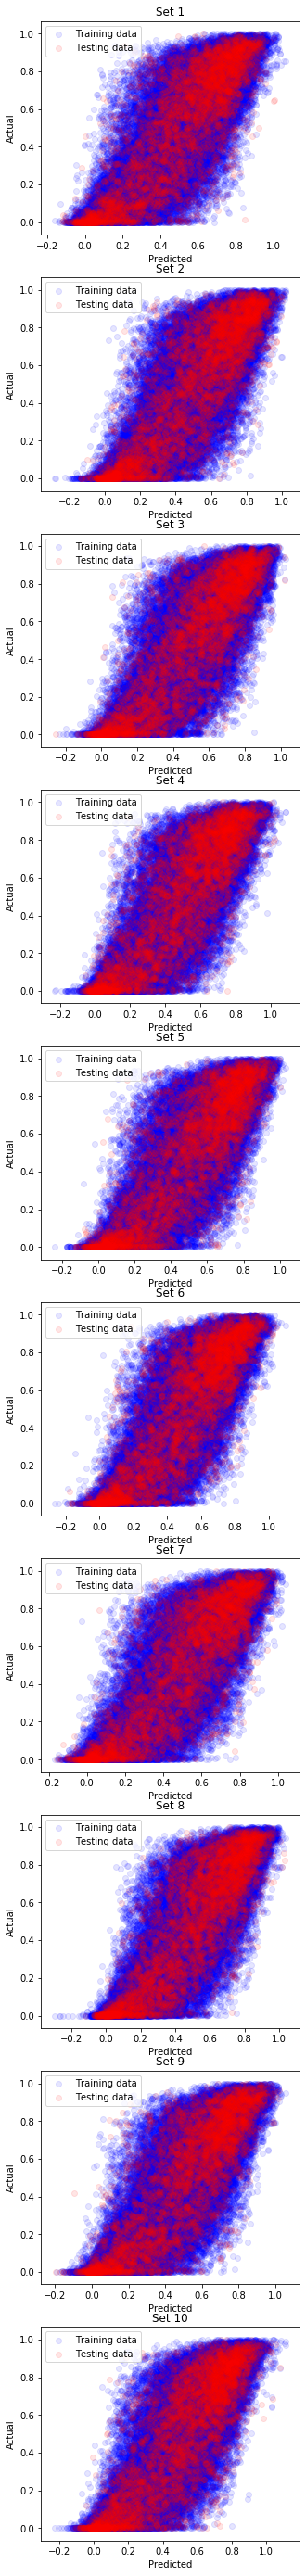

In [11]:
kf = KFold(n_splits=10,random_state=1,shuffle=True)# Define the split - into 100 folds 

fig, axs = plt.subplots(10, 1, figsize=(5,50))

i=0

for train_index, test_index in kf.split(X_normalized, y_pn):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, y_train = X_normalized[train_index], y_pn[train_index].reshape(-1)
    X_test, y_test = X_normalized[test_index], y_pn[test_index].reshape(-1)
    clf = MLPRegressor(solver='lbfgs',hidden_layer_sizes=(50,50))
    clf.fit(X_train,y_train)
    print('Set '+str(i+1))
    print('R-squared of training data is: '+"{:.3f}".format(r2_score(y_train,clf.predict(X_train)))+', '+"{:.3f}".format(clf.score(X_train,y_train)))
    print('R-squared of testing data is: '+"{:.3f}".format(r2_score(y_test,clf.predict(X_test)))+', '+"{:.3f}".format(clf.score(X_test,y_test)))
    axs[i].scatter(clf.predict(X_train), y_train, alpha = 0.1, color='blue')
    axs[i].scatter(clf.predict(X_test), y_test, alpha = 0.1, color='red')
    axs[i].set_title('Set '+str(i+1), fontsize=12)
    axs[i].set_xlabel('Predicted')
    axs[i].set_ylabel('Actual')
    axs[i].legend(('Training data', 'Testing data'))
    i=i+1

### KFold validation using 3 hidden layers with 25 nodes each:

TRAIN: [    0     1     2 ... 51466 51467 51468] TEST: [   10    28    44 ... 51437 51442 51444]
Set 1
R-squared of training data is: 0.674, 0.674
R-squared of testing data is: 0.649, 0.649
TRAIN: [    0     1     3 ... 51466 51467 51468] TEST: [    2    12    23 ... 51416 51417 51435]
Set 2
R-squared of training data is: 0.671, 0.671
R-squared of testing data is: 0.667, 0.667
TRAIN: [    0     1     2 ... 51466 51467 51468] TEST: [    3     8    11 ... 51436 51449 51465]
Set 3
R-squared of training data is: 0.679, 0.679
R-squared of testing data is: 0.669, 0.669
TRAIN: [    0     1     2 ... 51465 51467 51468] TEST: [   19    21    22 ... 51462 51463 51466]
Set 4
R-squared of training data is: 0.672, 0.672
R-squared of testing data is: 0.647, 0.647
TRAIN: [    0     1     2 ... 51466 51467 51468] TEST: [   26    35    36 ... 51403 51405 51424]
Set 5
R-squared of training data is: 0.659, 0.659
R-squared of testing data is: 0.657, 0.657
TRAIN: [    1     2     3 ... 51466 51467 51468] T

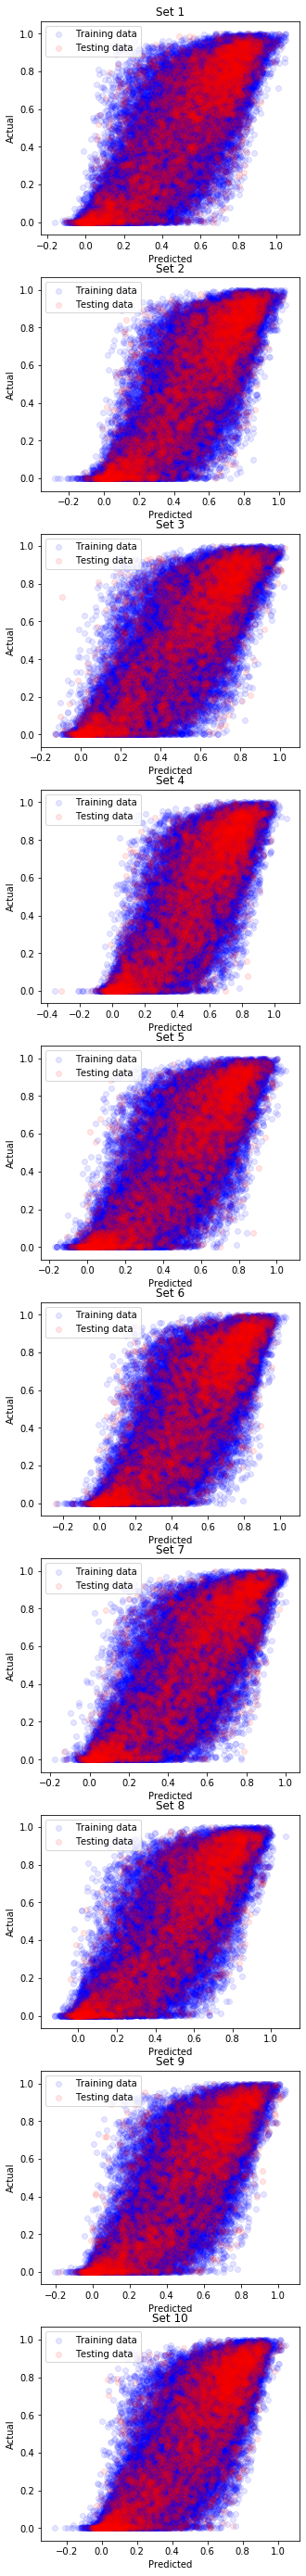

In [17]:
kf = KFold(n_splits=10,random_state=1,shuffle=True)# Define the split - into 100 folds 

fig, axs = plt.subplots(10, 1, figsize=(5,50))

i=0                                   

for train_index, test_index in kf.split(X_normalized, y_pn):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, y_train = X_normalized[train_index], y_pn[train_index].reshape(-1)
    X_test, y_test = X_normalized[test_index], y_pn[test_index].reshape(-1)
    clf = MLPRegressor(solver='lbfgs',hidden_layer_sizes=(25,25,25))
    clf.fit(X_train,y_train)
    print('Set '+str(i+1))
    print('R-squared of training data is: '+"{:.3f}".format(r2_score(y_train,clf.predict(X_train)))+', '+"{:.3f}".format(clf.score(X_train,y_train)))
    print('R-squared of testing data is: '+"{:.3f}".format(r2_score(y_test,clf.predict(X_test)))+', '+"{:.3f}".format(clf.score(X_test,y_test)))
    axs[i].scatter(clf.predict(X_train), y_train, alpha = 0.1, color='blue')
    axs[i].scatter(clf.predict(X_test), y_test, alpha = 0.1, color='red')
    axs[i].set_title('Set '+str(i+1), fontsize=12)
    axs[i].set_xlabel('Predicted')
    axs[i].set_ylabel('Actual')
    axs[i].legend(('Training data', 'Testing data'))
    i=i+1